In [82]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from skimage.metrics import peak_signal_noise_ratio as psnr_skimage
from skimage.metrics import structural_similarity as ssim_skimage
from pytorch_msssim import ssim as ssim_pytorch

def calculate_metrics(img1, img2):
    # Ensure the inputs are torch Tensors with the same shape
    img1 = torch.tensor(img1)
    img2 = torch.tensor(img2)
    
    # Convert to float32 and ensure the same device
    img1 = img1.float()
    img2 = img2.float()

    # Calculate Mean Squared Error (MSE)
    mse = F.mse_loss(img1, img2).item()

    # Calculate Peak Signal-to-Noise Ratio (PSNR)
    psnr = psnr_skimage(img1.cpu().numpy(), img2.cpu().numpy(), data_range=img2.max().item())

    # Calculate Structural Similarity Index (SSI)
    ssim_value = ssim_pytorch(img1, img2, data_range=img2.max().item()).item()

    return mse, psnr, ssim_value

# Example usage:
# Assuming img1 and img2 are your input images (numpy arrays or torch Tensors)
# Note: Images should be in the range [0, 1] for proper calculation
# img1 = torch.randn(1,3,25,25)
# img2 = torch.randn(1,3,25,25)

# mse, psnr, ssim = calculate_metrics(img1, img2)

# print(f"MSE: {mse}")
# print(f"PSNR: {psnr}")
# print(f"SSIM: {ssim}")


In [83]:
from model.model import *
from utils.utils import *
from utils.dataset import *
from loss.loss import *

In [84]:
def get_img(inputs):
    batch_size = inputs[0].size(0)

    r1 = inputs[0][:, 0, :, :].unsqueeze(1)
    g1 = inputs[0][:, 1, :, :].unsqueeze(1)
    b1 = inputs[1][:, 1, :, :].unsqueeze(1)

    r2 = inputs[1][:, 0, :, :].unsqueeze(1)
    g2 = inputs[2][:, 0, :, :].unsqueeze(1)
    b2 = inputs[2][:, 1, :, :].unsqueeze(1)

    img1 = torch.cat([r1, g1, b1], dim=1)
    img2 = torch.cat([r2, g2, b2], dim=1)

    return img1, img2

In [85]:
def preprocess2(img):
    red= img[:,0,:,:]
    green= img[:,1,:,:]
    blue= img[:,2,:,:]

    # blank_canvas = torch.zeros_like(red)
    # RG = torch.stack([red,green,blank_canvas],dim=0).unsqueeze(0)
    # RB = torch.stack([red,blank_canvas,blue],dim=0).unsqueeze(0)
    # GB = torch.stack([blank_canvas,green,blue],dim=0).unsqueeze(0)
    
    RG = torch.stack([red,green],dim=1)
    RB = torch.stack([red,blue],dim=1)
    GB = torch.stack([green,blue],dim=1)
    #print(RG.shape)

    return RG,RB,GB

In [86]:
import os
from torch.utils.data import DataLoader,Dataset
from PIL import Image
from torchvision.transforms import v2
import numpy as np

class CustomImageDataset2(Dataset):
    def __init__(self, train_dir, label_dir, transform=None):
        self.train_dir = train_dir
        self.label_dir = label_dir
        self.transform = transform
        self.train_image_paths = [os.path.join(train_dir, filename) for filename in os.listdir(train_dir)]
        self.label_image_paths = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]

    def __len__(self):
        return len(self.train_image_paths)

    def __getitem__(self, idx):
        train_image_path = self.train_image_paths[idx]
        label_image_path = self.label_image_paths[idx]

        train_image = Image.open(train_image_path)
        label_image = Image.open(label_image_path)
        # train_image = (np.asarray(train_image)/255.0)
        # label_image = (np.asarray(label_image)/255.0)

        if self.transform:
            train_image = self.transform(train_image)
            label_image = self.transform(label_image)


        return train_image, label_image

def load_data2(train_path, label_path):
    data_transforms = v2.Compose([
        v2.Resize(size=(60,90 )),
        #v2.RandomCrop(size=(32, 32)),
        v2.ToTensor()
        #v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    custom_dataset = CustomImageDataset2(
        train_dir=train_path,
        label_dir=label_path,
        transform=data_transforms
    )

    data_loader = DataLoader(
        dataset=custom_dataset,
        batch_size=1,
        num_workers=1,
        #shuffle=True
    )
    return data_loader

In [87]:
test_data_dir = '/home/zera/test'
label_data_dir = '/home/zera/test_label'
# Specify the paths to your training and label image directories


# Load the data using the load_data function
data_loader = load_data(test_data_dir, label_data_dir)

In [155]:
pred = []

ccn = CCN_Model()
ccn.load_state_dict(torch.load('/home/zera/ImageProcessingProject/ccn_model.pth',map_location='cpu'))
ccn.eval()

mfn = MFN()
mfn.load_state_dict(torch.load('/home/zera/ImageProcessingProject/mfn_model_V1.pth',map_location='cpu'))
mfn.eval()

den = DEN()
den.load_state_dict(torch.load('/home/zera/ImageProcessingProject/den_model_v1.pth',map_location='cpu'))
den.eval()

#den.eval()
label_img =[]
test_inp=[]
for data in data_loader:
    with torch.no_grad():
           
        input_img = preprocess(data[0])
          
        
            
        ccn_output = ccn(input_img)
        #ccn_input = get_img(data[0])

        im1,im2 = get_img(ccn_output)
        mfn_output = mfn(im1*im2)
        #print(mfn_output.shape)
        mfn_output+=(im1+im2)#-(im1*im1)
        
        den_inp = arithmetic_mean_filter(mfn_output)
        den_output = den(den_inp)
        

        

        pred.append(mfn_output+den_output)
        
        label_img.append(data[1])
        test_inp.append(data[0])
        
        

In [149]:
import matplotlib.pyplot as plt
import cv2
def display(image):
    # Assuming you have a tensor named 'image_tensor'
    # First, convert the tensor to a NumPy array
    image_array = image.numpy()[0] # For PyTorch tensors
    # For TensorFlow tensors, you can use: image_array = image_tensor.numpy()
    image_array = image_array.transpose((1, 2, 0))
    # Now, you can display the image using Matplotlib
    plt.imshow(image_array)
    plt.show()

In [153]:
def display_side_by_side(img1, img2,img3,title3 = "Input Image", title1='Model Enhanced', title2='Original'):
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 3,figsize =(10,16))
    image_array_1= img1.numpy()[0] # For PyTorch tensors
    # For TensorFlow tensors, you can use: image_array = image_tensor.numpy()
    image_array_1 = image_array_1.transpose((1, 2, 0))

    image_array_2= img2.numpy()[0] # For PyTorch tensors
    # For TensorFlow tensors, you can use: image_array = image_tensor.numpy()
    image_array_2 = image_array_2.transpose((1, 2, 0))



    image_array_3= img3.numpy()[0] # For PyTorch tensors
    # For TensorFlow tensors, you can use: image_array = image_tensor.numpy()
    image_array_3 = image_array_3.transpose((1, 2, 0))

    # Display the first image
    axes[0].imshow( image_array_1)
    axes[0].set_title(title1)
    axes[0].axis('off')

    # Display the second image
    axes[1].imshow(image_array_2)
    axes[1].set_title(title2)
    axes[1].axis('off')

     # Display the second image
    axes[2].imshow(image_array_3)
    axes[2].set_title(title3)
    axes[2].axis('off')


    # Show the images side by side
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


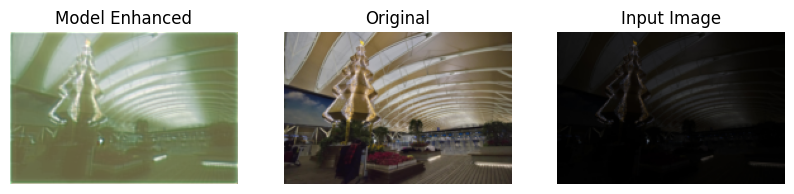

In [154]:
display_side_by_side(pred[0],label_img[0],test_inp[0])

In [156]:
ctr =0
tot_mse=0
tot_psnr = 0
tot_ssim =0
for img,label in zip(pred,label_img):
    mse, psnr, ssim = calculate_metrics(img, label)
    tot_mse+=mse
    tot_psnr+=psnr
    tot_ssim+=ssim


print(f"Average MSE: {tot_mse/len(pred)}")
print(f"Average PSNR: {tot_psnr/len(pred)}")
print(f"Average SSIM: {tot_ssim/len(pred)}")


Average MSE: 0.08895822614431381
Average PSNR: 10.301322012831056
Average SSIM: 0.6597381234169006


/tmp/ipykernel_85693/1576369860.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img1 = torch.tensor(img1)
/tmp/ipykernel_85693/1576369860.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img2 = torch.tensor(img2)
